# Part I - Ford GoBike Dataset Exploration 
## by Darragh Merrick

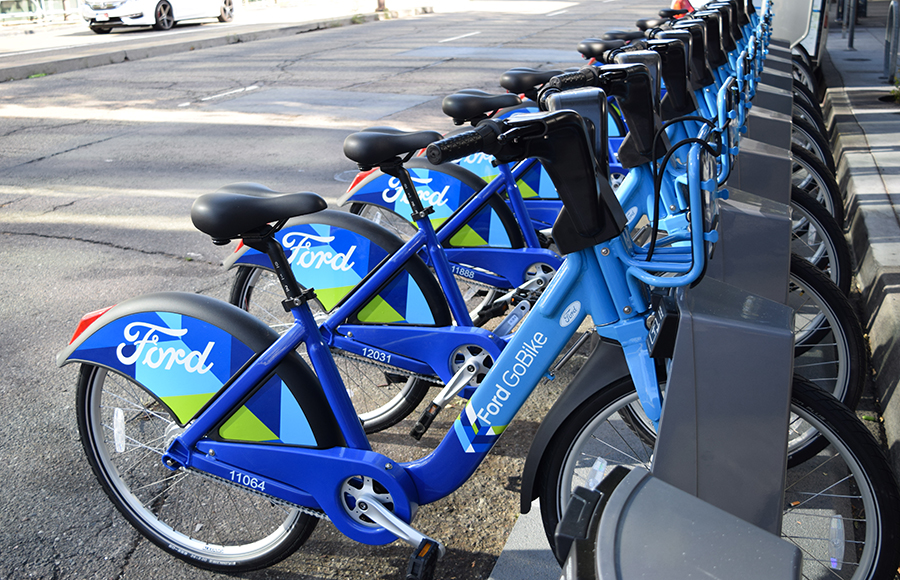

## Introduction

### Dataset Overview and Notes

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.

*Note* that this dataset will require some data wrangling in order to make it tidy for analysis. There are multiple cities covered by the linked system, and multiple data files will need to be joined together if a full year’s coverage is desired.
If you’re feeling adventurous, try adding in analysis from other cities, following links from [this page](https://github.com/BetaNYC/Bike-Share-Data-Best-Practices/wiki/Bike-Share-Data-Systems).

### Example Topics/Questions
When are most trips taken in terms of time of day, day of the week, or month of the year?

How long does the average trip take?

Does the above depend on if a user is a subscriber or customer?

>**Rubric Tip**: Your code should not generate any errors, and should use functions, loops where possible to reduce repetitive code. Prefer to use functions to reuse code statements.

> **Rubric Tip**: Document your approach and findings in markdown cells. Use comments and docstrings in code cells to document the code functionality.

>**Rubric Tip**: Markup cells should have headers and text that organize your thoughts, findings, and what you plan on investigating next.  



## Preliminary Wrangling


In [801]:
# import all packages and set plots to be embedded inline
from requests import get
from zipfile import ZipFile
from io import StringIO, BytesIO
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as ms
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas as gpd
import folium
from shapely.geometry import Point, Polygon
import haversine as hs


%matplotlib inline

> Load in your dataset and describe its properties through the questions below. Try and motivate your exploration goals through this section.


In [802]:
url = 'https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv'
data_csv = get(url)
data_csv
#<Response [200]> = Success

<Response [200]>

In [803]:
df = pd.read_csv(StringIO(data_csv.content.decode('utf-8')))
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [804]:
df.shape

(183412, 16)

In [805]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [806]:
df.isna().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64

In [807]:
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,183412.000000,183215.000000,183412.000000,183412.000000,183215.000000,183412.000000,183412.000000,183412.000000,175147.000000
mean,726.078435,138.590427,37.771223,-122.352664,136.249123,37.771427,-122.352250,4472.906375,1984.806437
std,1794.389780,111.778864,0.099581,0.117097,111.515131,0.099490,0.116673,1664.383394,10.116689
min,61.000000,3.000000,37.317298,-122.453704,3.000000,37.317298,-122.453704,11.000000,1878.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,3777.000000,1980.000000
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,4958.000000,1987.000000
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,5502.000000,1992.000000
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,6645.000000,2001.000000


In [808]:
df.duplicated().sum()

0

## Data Cleaning

#### Missing data
Visualise missing data in the dataset

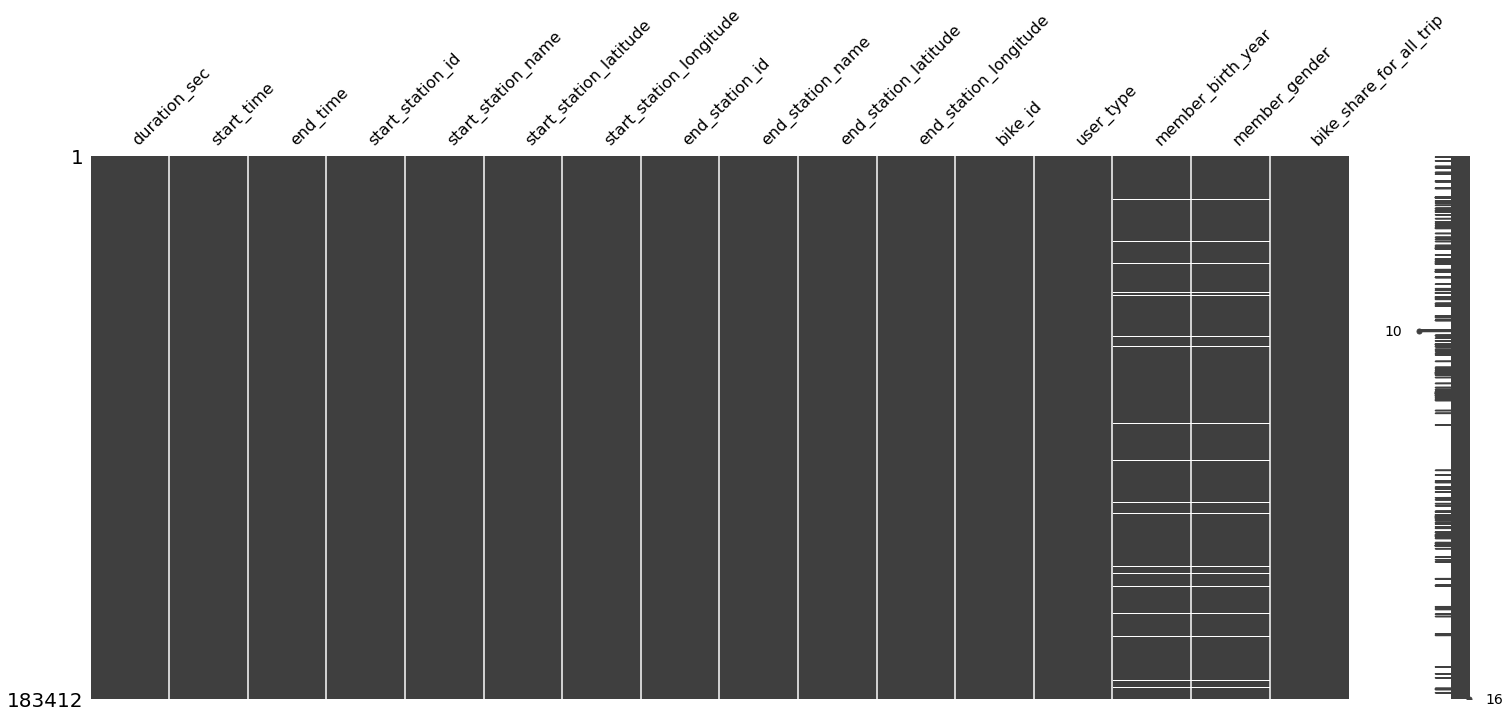

In [809]:
ms.matrix(df);

There are quality and tidiness issues in the data, that will need to be addressed.
The datatypes of multiple columns will need to be changed to gain insights such as:

* start_time  object to datetime64
* end_time object to datetime64
* start_station_id float64 to object
* end_station_id   float64 to object
* start_station_latitude  float64
* start_station_longitude float64
* end_station_latitude float64
* end_station_longitude float64
* bike_id int64 to object 
* member_birth_year float64 to int64

There are missing values in:
* start_station_id            197
* start_station_name          197
* end_station_id              197
* end_station_name            197
* member_birth_year          8265
* member_gender              8265

There are also invalid birth year values

There are other elements I could add like distance between start and stop, which would add useful information.

I would like to visualize the start and end locations on a map, which could also add useful information to this data study, even though it's not covered on this course.

In [810]:
df.dropna(subset = ["start_station_id"], inplace = True)
df.member_birth_year.fillna(0, inplace = True)
df.member_gender.fillna("not defined", inplace = True)

In [811]:
df['start_time'] = pd.to_datetime(df['start_time'], format = "%Y-%m-%d ")
df['end_time'] = pd.to_datetime(df['end_time'], format = "%Y-%m-%d ")
df['duration_sec'] = df['duration_sec'].astype(int)
df['start_station_id'] = df['start_station_id'].astype(str)
df['end_station_id'] = df['end_station_id'].astype(str)
df['start_station_latitude'] = df['start_station_latitude'].astype(float)
df['start_station_longitude'] = df['start_station_longitude'].astype(float)
df['end_station_latitude'] = df['end_station_latitude'].astype(float)
df['end_station_longitude'] = df['end_station_longitude'].astype(float)
df['start_time'] = pd.to_datetime(df['start_time'], format = "%Y-%m-%d ")
df['bike_id'] = df['bike_id'].astype(str)
df['member_birth_year'] = df['member_birth_year'].astype(int)
#df['member_birth_year'] = df[df['member_birth_year'] < 2015] 

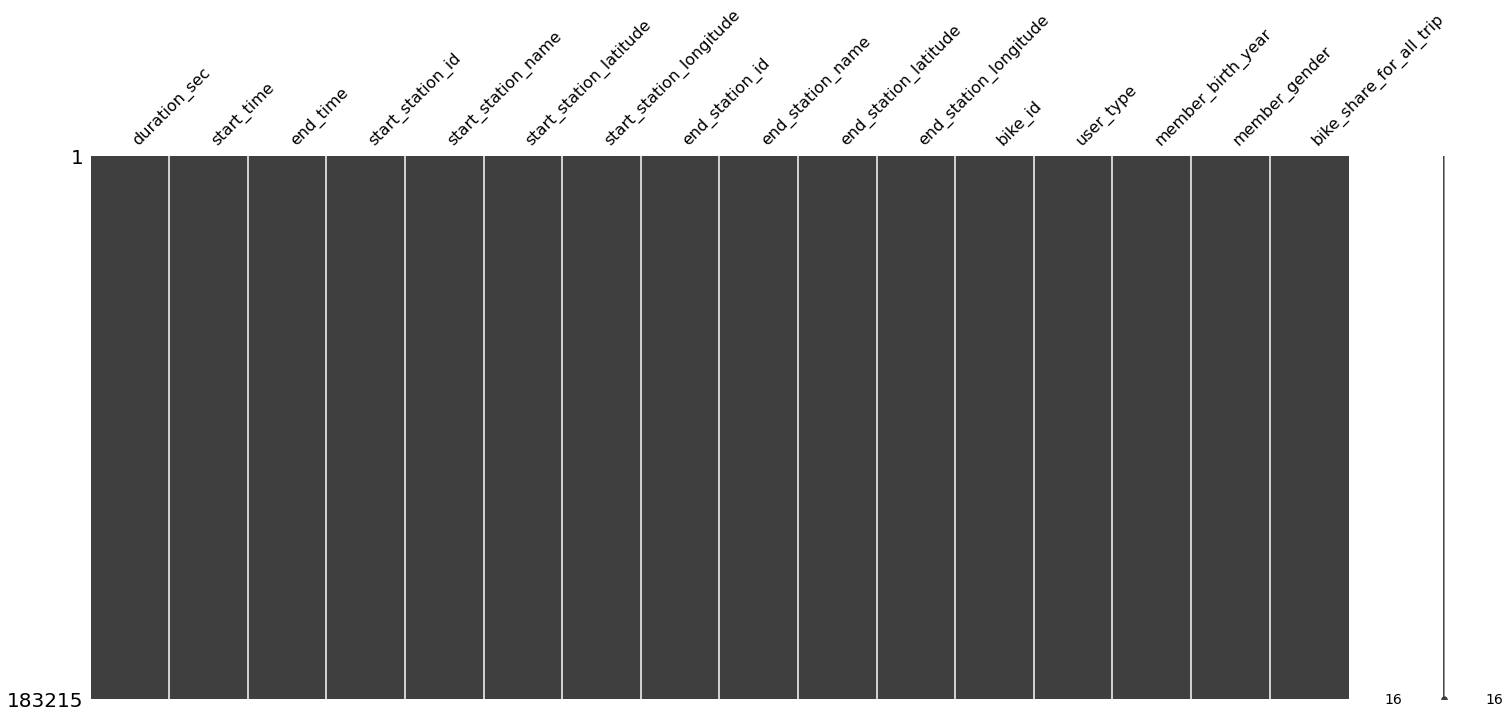

In [812]:
ms.matrix(df);

### What is the structure of your dataset?

> The dataset has 183412 rows and 16 columns.


## Exploratory Data Visualizations

In [813]:
#Make a new dataframe for geocode data analysis
geo_df = pd.DataFrame()
geo_df['start_lat'] = df['start_station_latitude']
geo_df['start_long'] = df['start_station_longitude']
geo_df['end_lat'] = df['end_station_latitude']
geo_df['end_long'] = df['end_station_longitude']
geo_df['duration_sec'] = df['duration_sec']
geo_df['date'] = df['start_time']
geo_df['member_birth_year'] =  df['member_birth_year']
geo_df['member_gender'] = df['member_gender']
geo_df = geo_df.astype(str)
i=0
rows = geo_df.shape[0]

geo_df.dtypes
geo_df['trips'] = "Start Location: " + ',' + geo_df['start_lat'].map(str) + ',' + geo_df['start_long'].map(str) + ',' + "End Location: " + ',' + geo_df['end_lat'].map(str) + ',' + geo_df['end_long']

trip_counts = geo_df['trips'].value_counts()
#print(trip_counts)


In [814]:
top_trips = trip_counts.head(10)
#print(top_trips)
#print(len(top_trips))

In [815]:
trip_counts_percentage = geo_df['trips'].value_counts(normalize=True)
print("Key : {} , Value : {}".format(trip_counts_percentage.index[0],trip_counts_percentage[0]))

Key : Start Location: ,37.77588,-122.39317,End Location: ,37.795392,-122.394203 , Value : 0.0018393690472941625


In [816]:
print(trip_counts.index)

Index(['Start Location: ,37.77588,-122.39317,End Location: ,37.795392,-122.394203',
       'Start Location: ,37.795392,-122.394203,End Location: ,37.80477,-122.403234',
       'Start Location: ,37.80889393398715,-122.25646018981932,End Location: ,37.8090126,-122.2682473',
       'Start Location: ,37.80477,-122.403234,End Location: ,37.79413,-122.39443',
       'Start Location: ,37.8090126,-122.2682473,End Location: ,37.80889393398715,-122.25646018981932',
       'Start Location: ,37.776619,-122.417385,End Location: ,37.7896254,-122.400811',
       'Start Location: ,37.771058,-122.402717,End Location: ,37.7766392,-122.3955263',
       'Start Location: ,37.3371223728942,-121.88321471214294,End Location: ,37.3259984,-121.87712',
       'Start Location: ,37.776619,-122.417385,End Location: ,37.78637526861584,-122.40490436553954',
       'Start Location: ,37.3259984,-121.87712,End Location: ,37.3371223728942,-121.88321471214294',
       ...
       'Start Location: ,37.745738796183325,-122.4

In [817]:
print(trip_counts.values)

[337 314 310 ...   1   1   1]


In [818]:
print(len(trip_counts))
print(trip_counts.median())
print(trip_counts.min())
print(trip_counts.max())

23648
3.0
1
337


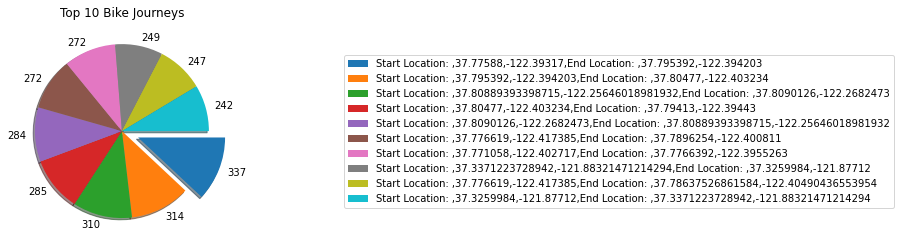

In [819]:
#Pie Chart to visualize the top journeys
values = top_trips.values
labels = top_trips.index
explode = (0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(values, labels= values,explode=explode,counterclock=False, shadow=True)
plt.title('Top 10 Bike Journeys')
plt.legend(labels, loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.show()

In [820]:
#top 500 is the most the jupyter notebook can handle without crashing or becoming to slow.
n = 500
top_trips = geo_df['trips'].value_counts().index.tolist()[:n]
#print(top_trips)

In [821]:
print(geo_df.shape[0])


183215


In [600]:
my_map = folium.Map(location=(37.7693053,-122.4268256), zoom_start=11);
i=0
limit = len(top_trips)
while i < limit:
    trip = top_trips[i].split(',')
    #print(trip)
    #print('Trip: ',i,'Start LatLong: ',trip[0],trip[1],'End LatLong: ',trip[2],trip[3])
    folium.Marker(location=(trip[1],trip[2]),popup='Start trip:'+str(i),icon=folium.Icon(color='green',icon='circle')).add_to(my_map)
    folium.Marker(location=(trip[4],trip[5]),popup='End trip:'+str(i),icon=folium.Icon(color='red', icon='square')).add_to(my_map)
    i+=1
#folium.Marker(location=(geo_df['start_lat'].iloc[0],geo_df['start_long'].iloc[0]),popup=i,icon=folium.Icon(color='green',icon='info-sign')).add_to(my_map)
#folium.Marker(location=(geo_df['end_lat'].iloc[0],geo_df['start_long'].iloc[0]),popup=i,icon=folium.Icon(color='red', icon='info-sign')).add_to(my_map)

#folium.Marker(location=(geo_df['start_lat'].iloc[1],geo_df['start_long'].iloc[1]),popup=i,icon=folium.Icon(color='green',icon='info-sign')).add_to(my_map)
#folium.Marker(location=(geo_df['end_lat'].iloc[1],geo_df['start_long'].iloc[1]),popup=i,icon=folium.Icon(color='red', icon='info-sign')).add_to(my_map)
display(my_map)


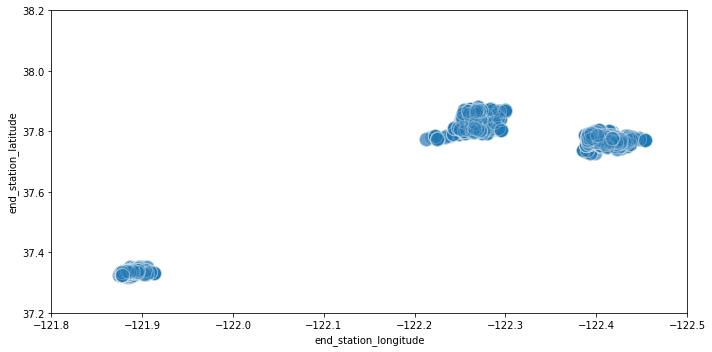

In [1334]:
axes, figure = plt.subplots(figsize = (10,5))
sns.scatterplot(data = df[df.start_station_id.isnull()], x = "end_station_longitude", y = "end_station_latitude", alpha = 0.15, s = 200)
sns.scatterplot(data = df.dropna(subset=["end_station_id"]).sample(50000), x = "end_station_longitude", y = "end_station_latitude", alpha = 0.15, s = 200)
plt.xlim(-121.8,-122.5)
plt.ylim(37.2,38.2)
plt.tight_layout()

### Formula to calculate distance between 2 locations

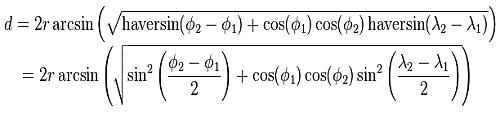


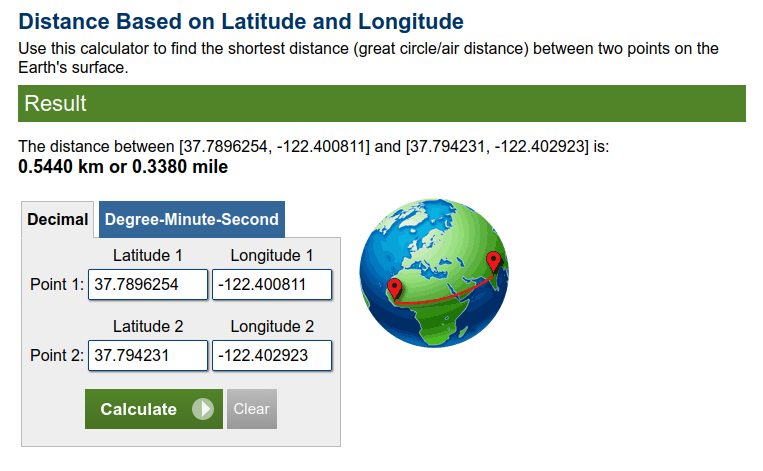

Tested results against online calculator
https://www.calculator.net/distance-calculator.html

In [828]:
#test function
from math import radians, sin, cos, acos
#geo_df['distances']=''
i=0
geo_df['distances'] = ''
print(geo_df['trips'].iloc[1610])
limit = geo_df.shape[0]
while i < limit:
    trip = geo_df['trips'].iloc[i].split(',')
    slat = radians(float(trip[1])) # start latitude
    slon = radians(float(trip[2])) # start longitude
    elat = radians(float(trip[4])) # end latitude
    elon = radians(float(trip[5])) # end longitude
        
    if(slat == elat and slon == elon):
        geo_df['distances'].iloc[i] = 0
        i+=1
    else:
        dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))
        #print(dist)
        geo_df['distances'].iloc[i] = round(dist,2)  
        i+=1
#print(geo_df['distances'].iloc[i])
#print("The distance is %.2fkm." % dist)

df['distances'] = geo_df['distances'] # Add this column to the main dataframe
geo_df.head(100)

Start Location: ,37.7671004,-122.410662,End Location: ,37.776619,-122.417385


,start_lat,start_long,end_lat,end_long,duration_sec,date,member_birth_year,member_gender,trips,distances
0,37.7896254,-122.400811,37.794231,-122.402923,52185,2019-02-28 17:32:10.145,1984,Male,"Start Location: ,37.7896254,-122.400811,End Lo...",0.54
1,37.791464,-122.391034,37.77588,-122.39317,42521,2019-02-28 18:53:21.789,0,not defined,"Start Location: ,37.791464,-122.391034,End Loc...",1.74
2,37.7693053,-122.4268256,37.78637526861584,-122.40490436553954,61854,2019-02-28 12:13:13.218,1972,Male,"Start Location: ,37.7693053,-122.4268256,End L...",2.7
3,37.77483629413345,-122.44654566049576,37.77331087889723,-122.44429260492323,36490,2019-02-28 17:54:26.010,1989,Other,"Start Location: ,37.77483629413345,-122.446545...",0.26
4,37.8045623549303,-122.27173805236816,37.7927143,-122.2487796,1585,2019-02-28 23:54:18.549,1974,Male,"Start Location: ,37.8045623549303,-122.2717380...",2.41
...,...,...,...,...,...,...,...,...,...,...
95,37.775946,-122.4377775,37.7552126,-122.4209752,815,2019-02-28 23:00:41.316,1994,Male,"Start Location: ,37.775946,-122.4377775,End Lo...",2.74
96,37.333955,-121.877349,37.3259984,-121.87712,229,2019-02-28 23:09:20.161,1996,Male,"Start Location: ,37.333955,-121.877349,End Loc...",0.88
97,37.8098236,-122.2801923,37.8098236,-122.2801923,497,2019-02-28 23:04:52.183,1992,Female,"Start Location: ,37.8098236,-122.2801923,End L...",0
98,37.8575672,-122.2675583,37.8723555,-122.2664467,549,2019-02-28 23:03:47.274,1994,Male,"Start Location: ,37.8575672,-122.2675583,End L...",1.65


In [1071]:
geo_df['distances'].replace(0, np.nan, inplace=True)
distance_counts = geo_df['distances'].value_counts(dropna=True)
distance_counts.head(20)

1.04    1953
1.35    1472
0.88    1391
1.37    1376
0.85    1368
1.41    1363
0.79    1359
1.24    1338
1.21    1282
0.86    1242
0.94    1240
0.75    1211
1.31    1186
1.13    1185
1.69    1184
0.60    1147
0.72    1134
0.84    1122
0.96    1118
1.54    1111
Name: distances, dtype: int64

1.04    1953
1.35    1472
0.88    1391
1.37    1376
0.85    1368
1.41    1363
0.79    1359
1.24    1338
1.21    1282
0.86    1242
Name: distances, dtype: int64


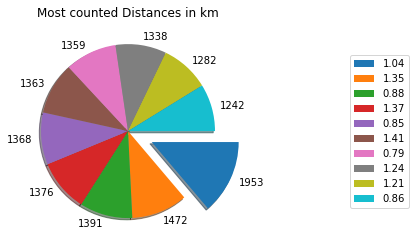

In [1073]:
sorted_dist = dist.sort_values(ascending=False)
top_dist = distance_counts.head(10)
print(top_dist)
values = top_dist.values
labels = top_dist.index
explode = (0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(values, labels= values,explode=explode,counterclock=False, shadow=True)
plt.title('Most counted Distances in km')
plt.legend(labels, loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.show()

69.47    1
15.67    1
14.10    1
13.89    1
13.59    1
12.41    1
12.33    1
11.71    1
11.55    1
11.53    2
Name: distances, dtype: int64


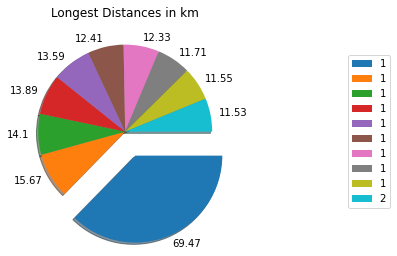

In [1106]:
dist = geo_df['distances'].value_counts()
#dist.drop_duplicates(inplace = True) 
sorted_dist = dist.sort_index(ascending=False)
top_dist = sorted_dist.head(10)
print(top_dist)
values = top_dist.values
indexs = top_dist.index
explode = (0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(indexs, labels= indexs,explode=explode,counterclock=False, shadow=True)
plt.title('Longest Distances in km')
plt.legend(values, loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.show()

In [1048]:
geo_df.to_csv(r'/home/pegasus/Dropbox/export_geo_df.csv', index = False, header=True)

In [964]:
geo_df.dtypes

start_lat             object
start_long            object
end_lat               object
end_long              object
duration_sec          object
date                  object
member_birth_year     object
member_gender         object
trips                 object
distances            float64
dtype: object

In [965]:
geo_df['distances'] = geo_df['distances'].astype(float)
geo_df['duration_sec'] = geo_df['duration_sec'].astype(int)
geo_df['member_birth_year'] = geo_df['member_birth_year'].astype(float)
geo_df['member_birth_year']
#geo_df['month'] = geo_df['duration_sec'].astype(datetime64[ns])
geo_df['date'] = pd.to_datetime(geo_df['date'], format = "%Y-%m-%d ")
geo_df.dtypes

start_lat                    object
start_long                   object
end_lat                      object
end_long                     object
duration_sec                  int64
date                 datetime64[ns]
member_birth_year           float64
member_gender                object
trips                        object
distances                   float64
dtype: object

In [966]:
# Create new column with distances and make it a float, so that I can preform mathematical functions on values
geo_df.head()

,start_lat,start_long,end_lat,end_long,duration_sec,date,member_birth_year,member_gender,trips,distances
0,37.7896254,-122.400811,37.794231,-122.402923,52185,2019-02-28 17:32:10.145,1984.0,Male,"Start Location: ,37.7896254,-122.400811,End Lo...",0.54
1,37.791464,-122.391034,37.77588,-122.39317,42521,2019-02-28 18:53:21.789,0.0,not defined,"Start Location: ,37.791464,-122.391034,End Loc...",1.74
2,37.7693053,-122.4268256,37.78637526861584,-122.40490436553954,61854,2019-02-28 12:13:13.218,1972.0,Male,"Start Location: ,37.7693053,-122.4268256,End L...",2.70
3,37.77483629413345,-122.44654566049576,37.77331087889723,-122.44429260492323,36490,2019-02-28 17:54:26.010,1989.0,Other,"Start Location: ,37.77483629413345,-122.446545...",0.26
4,37.8045623549303,-122.27173805236816,37.7927143,-122.2487796,1585,2019-02-28 23:54:18.549,1974.0,Male,"Start Location: ,37.8045623549303,-122.2717380...",2.41


In [967]:
#geo_df = geo_df[geo_df["distances"] < 60]
geo_df['distances'].max()

69.47

In [968]:
print(geo_df['distances'])

0         0.54
1         1.74
2         2.70
3         0.26
4         2.41
          ... 
183407    1.46
183408    1.40
183409    0.38
183410    0.75
183411    0.71
Name: distances, Length: 183215, dtype: float64


In [1219]:
geo_df["age"] = df["member_birth_year"].apply(lambda x: 2021 - int(x))

In [1220]:
df['month_year'] = pd.to_datetime(df["start_time"]).dt.to_period('M')

In [1221]:
df['day_month_year'] = pd.to_datetime(df["start_time"]).dt.to_period('D')

In [1222]:
df["dayofweek"] = df["start_time"].apply(lambda x: x.dayofweek)

In [1223]:
df["start_hr"] = df["start_time"].apply(lambda x: x.hour)
df["end_hr"] = df["end_time"].apply(lambda x: x.hour)

In [1224]:
bins = [x for x in range(10,101, 10)]
geo_df["age_bins"] = pd.cut(df.age, bins = bins, precision = 0, include_lowest=False)

In [1225]:
geo_df[["age", "age_bins"]].head()

,age,age_bins
0,37,"(30.0, 40.0]"
1,2021,NaN
2,49,"(40.0, 50.0]"
3,32,"(30.0, 40.0]"
4,47,"(40.0, 50.0]"


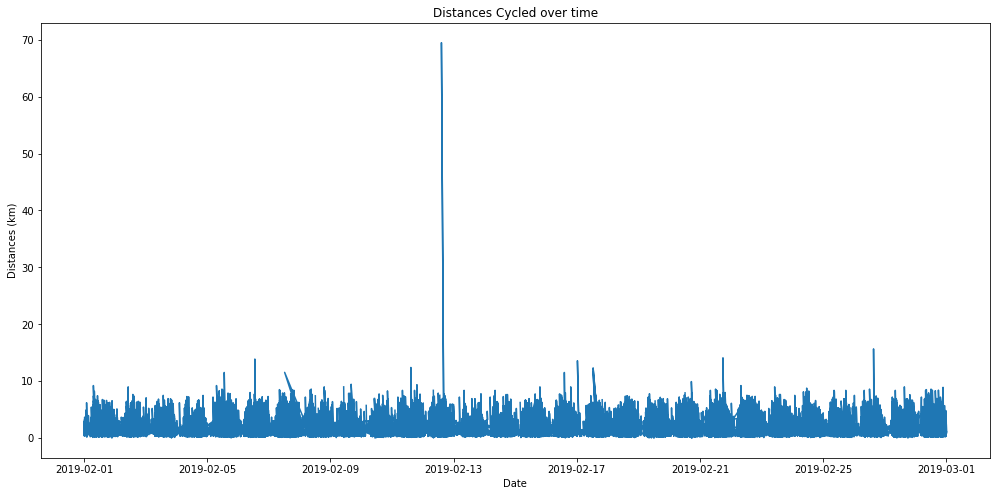

In [969]:
# Plotting time vs. Distances

plt.figure(figsize=(17, 8))

plt.xlabel('Date')
plt.ylabel('Distances (km)')

plt.plot(geo_df['date'],geo_df["distances"])
plt.title('Distances Cycled over time');

L-*0ooking at the 1 duration of 69.47:

| start_lat, long  |      end lat, long     |  duration |Distance
|:-------------:|:-------------:|:-------------:|:-------------:|
| 37.7896254,-122.400811 |  37.3172979,-121.884995 | 6945 seconds (1.93 hours)|69.47km

5km every 10 minutes is an estimated average, which would give me 30km over the hour, so this would not be impossible.

From the map below, it looks like someone cycled from San Francisco to San Jose.
This would not be impossible, so not going to filter it out as an outlier.

In [1133]:
my_map = folium.Map(location=(37.7693053,-122.4268256), zoom_start=8);
folium.Marker(location=(37.7896254,-122.400811 ),popup='Start of 69.47km trip:',icon=folium.Icon(color='green',icon='circle')).add_to(my_map)
folium.Marker(location=(37.3172979,-121.884995),popup='End of 69.47km trip:',icon=folium.Icon(color='red', icon='square')).add_to(my_map)
display(my_map)

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


> **Rubric Tip**: The project (Parts I alone) should have at least 15 visualizations distributed over univariate, bivariate, and multivariate plots to explore many relationships in the data set.  Use reasoning to justify the flow of the exploration.



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 


In [970]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,distances
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984,Male,No,0.54
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,0,not defined,No,1.74
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972,Male,No,2.7
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989,Other,No,0.26
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974,Male,Yes,2.41


In [971]:
#print(geo_df['distances'].value_counts())
print(geo_df['distances'].max())
print(geo_df['distances'].min())
print(geo_df['distances'].mean())

69.47
0.01
1.7273888613267612


In [1019]:
bin_edges = np.arange(0, 10, 0.5)
print(bin_edges)

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5
 9.  9.5]


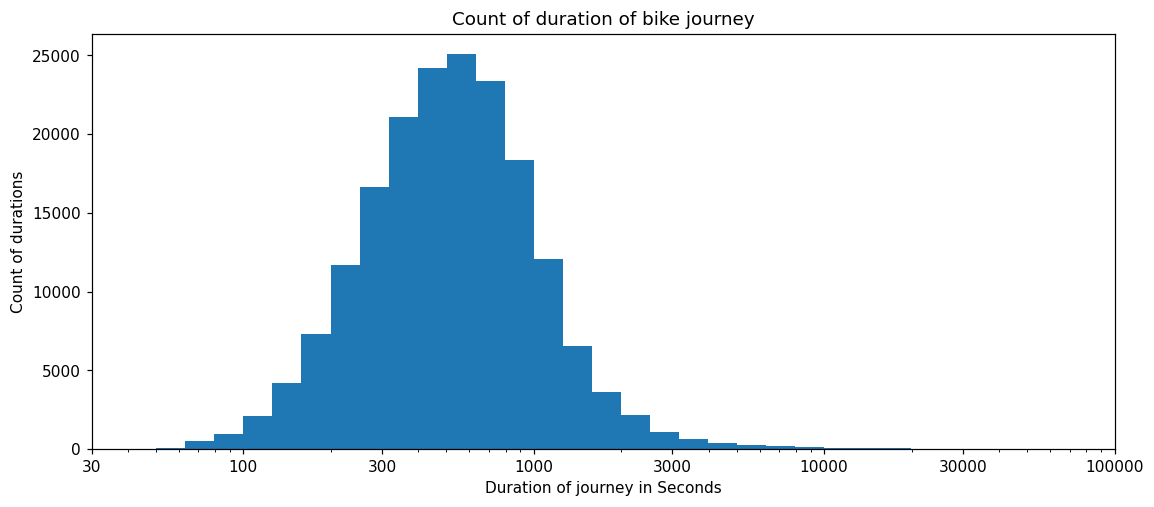

In [1027]:
bin_edges = 10 ** np.arange(0, 5, 0.1)
ticks = [30,100,300,1000,3000,10000,30000,100000]
fig, axes = plt.subplots(figsize = (12,5), dpi = 110)
labels = ['{}'.format(v) for v in ticks]
plt.hist(data = df, x ='duration_sec', bins = bin_edges);
plt.xscale("log");
plt.xlim(30, 10000);
plt.xticks(ticks,labels);
plt.title("Count of duration of bike journey");
plt.xlabel("Duration of journey in Seconds");
plt.ylabel("Count of durations");


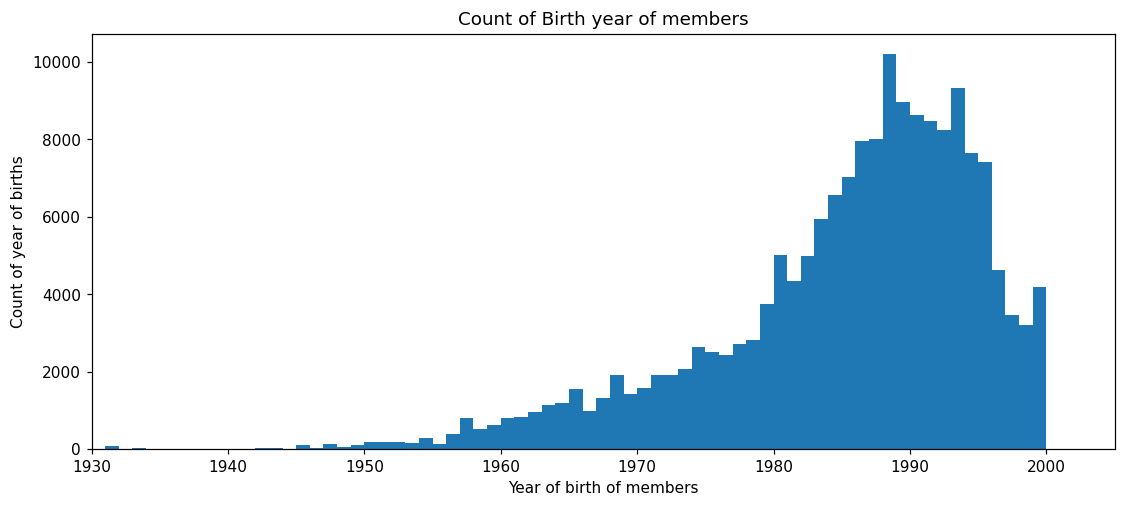

In [1011]:
bin_edges = np.arange(df['member_birth_year'].min(),df['member_birth_year'].max(), 1)
fig, axes = plt.subplots(figsize = (12,5), dpi = 110)
plt.hist(data = df, x ='member_birth_year', bins = bin_edges);
plt.xlim(1930, 2005);
plt.title("Count of Birth year of members");
plt.xlabel("Year of birth of members");
plt.ylabel("Count of year of births");

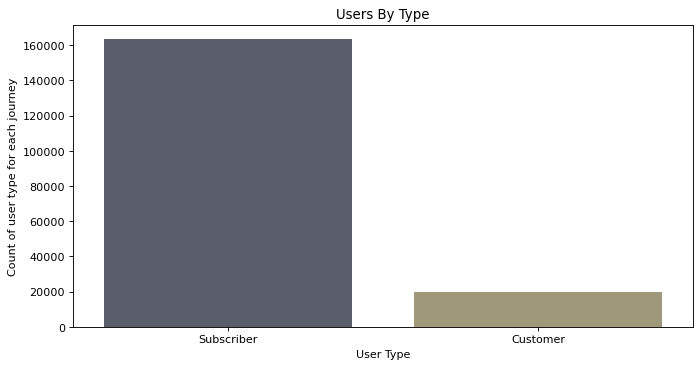

In [998]:
values = df.user_type.value_counts()

fig, ax = plt.subplots(figsize = (10,5), dpi = 80)
sns.countplot(x = "user_type", data = df, order=values.index, palette = "cividis");

plt.title("Users By Type");
plt.xlabel("User Type");
plt.ylabel("Count of user type for each journey");

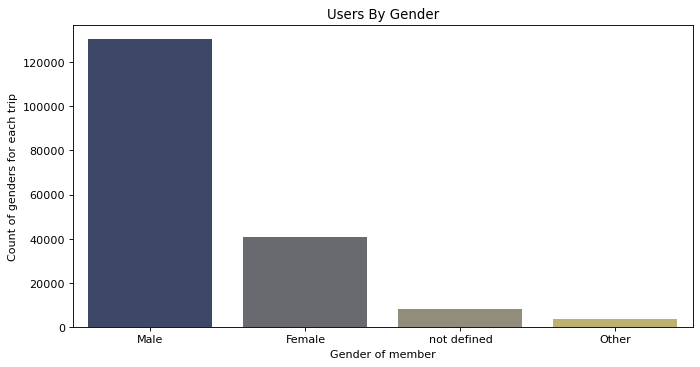

In [999]:
fig, ax = plt.subplots(figsize = (10,5), dpi = 80)
sns.countplot(x = "member_gender", data = df,  order=df.member_gender.value_counts().index, palette = "cividis");

plt.title("Users By Gender");
plt.xlabel("Gender of member");
plt.ylabel("Count of genders for each trip");

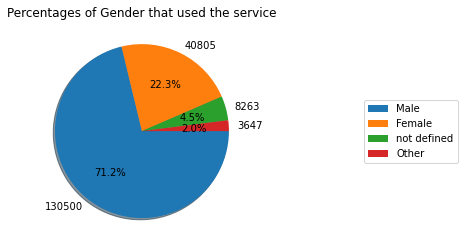

In [1175]:
gender = geo_df['member_gender'].value_counts()
#dist.drop_duplicates(inplace = True) 
sorted_gender = gender.sort_values(ascending=False)
#top_gender = sorted_dist.head(10)
values = sorted_gender.values
indexs = sorted_gender.index
explode = (0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(values, labels= values,counterclock=False, shadow=True, autopct='%1.1f%%')
plt.title('Percentages of Gender that used the service')
plt.legend(indexs, loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.show()

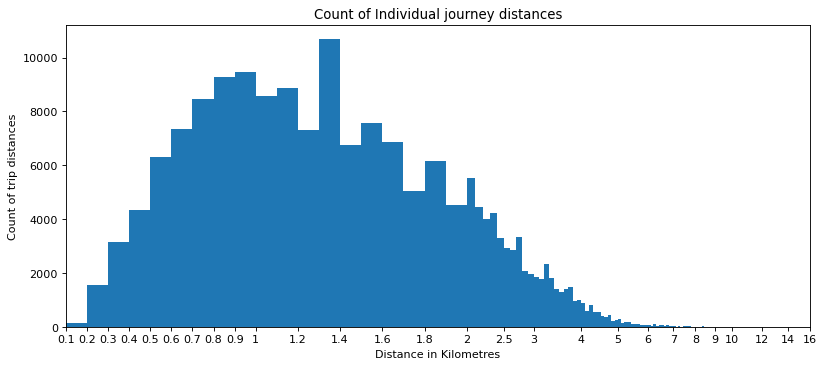

In [1064]:
fig, ax = plt.subplots(figsize = (12,5), dpi = 80)
bin_size = 0.1
bin_edges = np.arange(0,geo_df.distances.max()+bin_size,bin_size)
ticks = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.4,1.6,1.8,2,2.5,3,4,5,6,7,8,9,10,12,14,16]
labels = ['{}'.format(v) for v in ticks]
plt.hist(data = geo_df, x ='distances', bins = bin_edges);
plt.xscale("symlog");
plt.xlim(0.1, 16);
plt.xticks(ticks,labels);
plt.title("Count of Individual journey distances");
plt.xlabel("Distance in Kilometres");
plt.ylabel("Count of trip distances");

In [1110]:
#Let's calculate the age from the customer DOB
i=0
geo_df['ages'] = ''
current_year = 2021
limit = geo_df.shape[0]
birth_year = df['member_birth_year'].iloc[i]
while i < limit:
    age = current_year - df['member_birth_year'].iloc[i]
    geo_df['ages'].iloc[i] = age  
    i+=1
    
geo_df.head()

/home/pegasus/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,start_lat,start_long,end_lat,end_long,duration_sec,date,member_birth_year,member_gender,trips,distances,ages
0,37.7896254,-122.400811,37.794231,-122.402923,52185,2019-02-28 17:32:10.145,1984.0,Male,"Start Location: ,37.7896254,-122.400811,End Lo...",0.54,37
1,37.791464,-122.391034,37.77588,-122.39317,42521,2019-02-28 18:53:21.789,0.0,not defined,"Start Location: ,37.791464,-122.391034,End Loc...",1.74,2021
2,37.7693053,-122.4268256,37.78637526861584,-122.40490436553954,61854,2019-02-28 12:13:13.218,1972.0,Male,"Start Location: ,37.7693053,-122.4268256,End L...",2.70,49
3,37.77483629413345,-122.44654566049576,37.77331087889723,-122.44429260492323,36490,2019-02-28 17:54:26.010,1989.0,Other,"Start Location: ,37.77483629413345,-122.446545...",0.26,32
4,37.8045623549303,-122.27173805236816,37.7927143,-122.2487796,1585,2019-02-28 23:54:18.549,1974.0,Male,"Start Location: ,37.8045623549303,-122.2717380...",2.41,47


In [1111]:
geo_df.dtypes


start_lat                    object
start_long                   object
end_lat                      object
end_long                     object
duration_sec                  int64
date                 datetime64[ns]
member_birth_year           float64
member_gender                object
trips                        object
distances                   float64
ages                         object
dtype: object

In [1112]:
geo_df['ages'] = geo_df['ages'].astype(int)

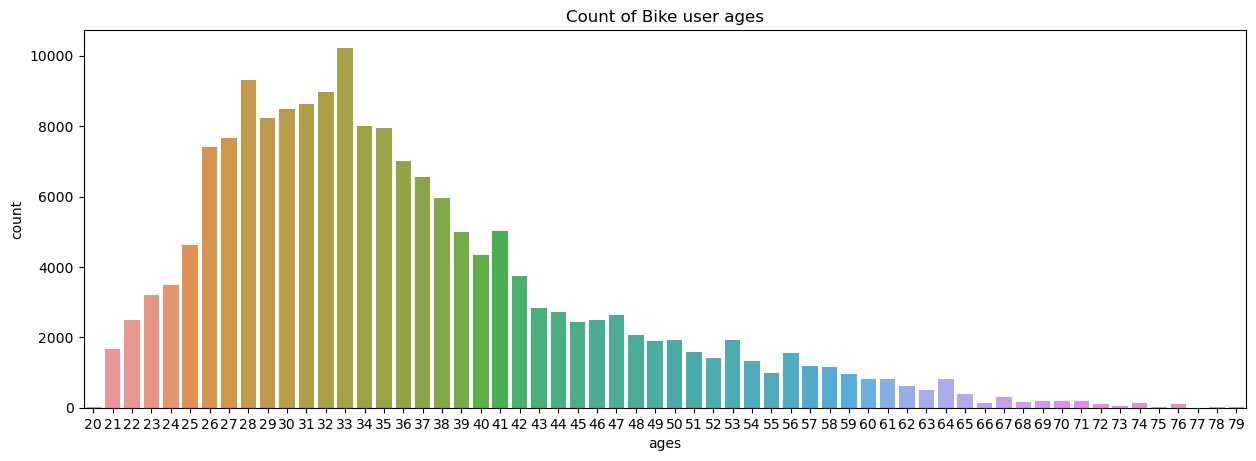

In [1375]:
fig, ax = plt.subplots(figsize = (15,5), dpi = 100)
color = sns.color_palette("cividis_r")
sns.countplot(x = "ages", data = geo_df.query("ages < 80").sort_values("ages"));
plt.title("Count of Bike user ages");

#plt.legend();

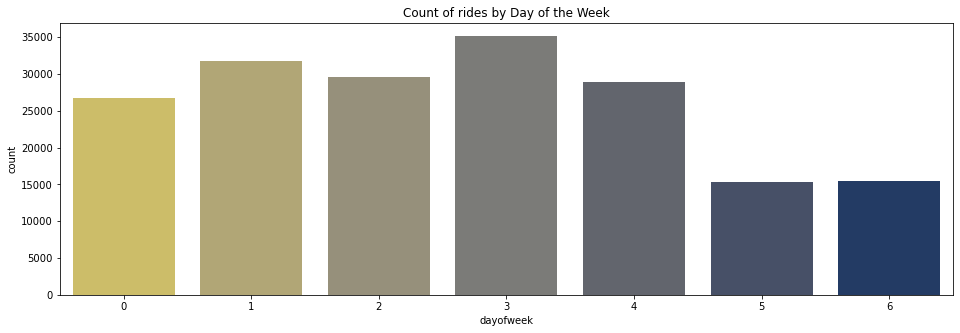

In [1376]:
fig, ax = plt.subplots(figsize = (16,5))
sns.countplot(x = "dayofweek", data = df, palette = "cividis_r");
plt.title("Count of rides by Day of the Week");

### What is/are the main feature(s) of interest in your dataset?

> The trip duration and start and end station Lat Longs could generate interesting results.
> Most popular start stations and end Stations could show interesting trends.
> Start and end times show year-month-day, so we can find trends of popular times, days, months and seasons.
> Statistics about gender and age may also show the most popular groups that tend to cycle.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Gender, Age and user type will help profile the customers
> Start_station_ID and End_Station_id will help find the most popular routes, to assist bike redistribution. Bikes will need to be moved from the most popular destinations to the most popular starting points to keep bikes available at popular starting points.
> start_time and end_time will help investigate cycle durations and peak times.



>**Rubric Tip**: Visualizations should depict the data appropriately so that the plots are easily interpretable. You should choose an appropriate plot type, data encodings, and formatting as needed. The formatting may include setting/adding the title, labels, legend, and comments. Also, do not overplot or incorrectly plot ordinal data.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> In the duration_sec graph, I used a log scale to get an uniform distribution.
> The count of Age and Distances are positively skewed distributions

*A distribution is said to be skewed to the right if it has a long tail that trails toward the right side. The skewness value of a positively skewed distribution is greater than zero.*

> The count of birth years is a negatively  skewed ditribution.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> I didn't find any of the results to be unusual. 
The most common age groupos were 25 -40
The most common trips were between 0.5 to 2.5 km, although there was one trip from San francisco to San Jose which was 69.47km.
I did find it surprising that over 70% of users were male, I would have expected a more even gender usage. 

In [1184]:
df['distances'] = df['distances'].astype(float)
df.dtypes


duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                   object
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                     object
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bike_id                            object
user_type                          object
member_birth_year                   int64
member_gender                      object
bike_share_for_all_trip            object
distances                         float64
dtype: object

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

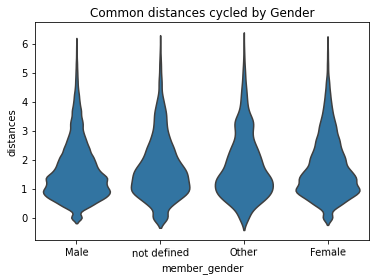

In [1340]:
sns.violinplot(data = df.query("distances <= 6"),x = 'member_gender',y='distances',color = sns.color_palette()[0],inner=None);
plt.xticks(rotation=1);
plt.title("Common distances cycled by Gender");

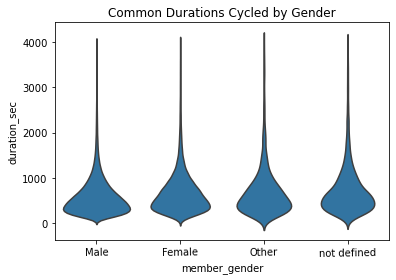

In [1339]:
sns.violinplot(data = df.query("duration_sec <= 4000"),x = 'member_gender',y='duration_sec',color = sns.color_palette()[0],inner=None);
plt.xticks(rotation=1);
plt.title("Common Durations Cycled by Gender");

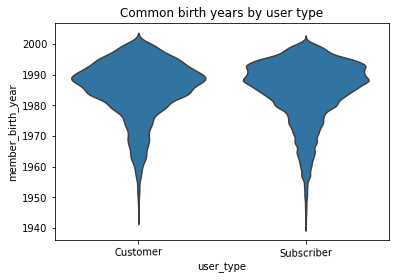

In [1338]:
sns.violinplot(data = df.query("member_birth_year >= 1940"),x = 'user_type',y='member_birth_year',color = sns.color_palette()[0],inner=None);
plt.xticks(rotation=1);
plt.title("Common birth years by user type");

In [1265]:
print('test')

test


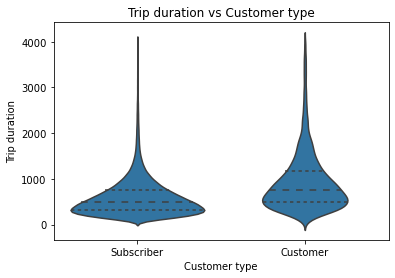

In [1384]:
sns.violinplot(data = df.query("duration_sec <= 4039.5"),x = 'user_type',y='duration_sec',color = sns.color_palette()[0],inner='quartile');
plt.title("Trip duration vs Customer type");
plt.xlabel("Customer type");
plt.ylabel("Trip duration");

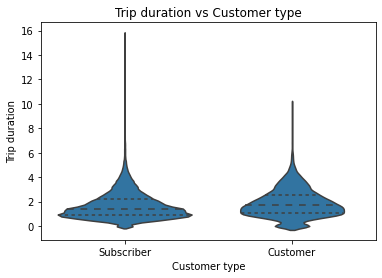

In [1385]:
sns.violinplot(data = df.query("duration_sec <= 4039.5"),x = 'user_type',y='distances',color = sns.color_palette()[0],inner='quartile');
plt.title("Trip duration vs Customer type");
plt.xlabel("Customer type");
plt.ylabel("Trip duration");

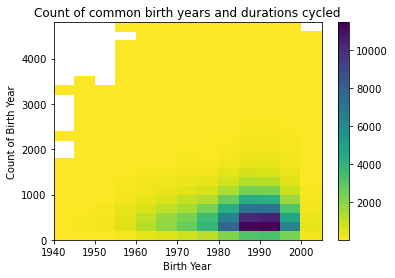

In [1345]:
xbin = np.arange(df['member_birth_year'].min(), df['member_birth_year'].max()+5, 5)
ybin = np.arange(0, 5000, 200)
plt.hist2d(data = df,x = 'member_birth_year',y='duration_sec',cmin=0.5,cmap = 'viridis_r',bins=[xbin, ybin]);
plt.xlim(1940, 2005);
plt.colorbar();
plt.title("Count of common birth years and durations cycled");
plt.xlabel("Birth Year");
plt.ylabel("Count of Birth Year");

Text(0, 0.5, 'duration_sec')

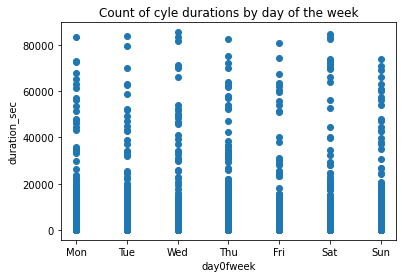

In [1346]:
# Scatter plot
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plt.scatter(data = df, x = 'dayofweek', y = 'duration_sec');
plt.xticks(range(len(days)), days, size='medium')
plt.title("Count of cyle durations by day of the week");
plt.xlabel('day0fweek')
plt.ylabel('duration_sec')

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

* The durations cycled each day do not vary greatly
* The group born between 1985 and 1995 are the most common and cycel for the longest durations.
* Customers tend to cycle longer distances and subscribers tend to cycle shorter distances more often.
* Younger users tend to be subscribers more than customers.
* Durations cycled does not vary greatly between genders.
* Males marginally cycle greater distances


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

* I found the data to be balanced. The most common users were born around 1985 and 1995 and cycled the farthest.
Usage

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

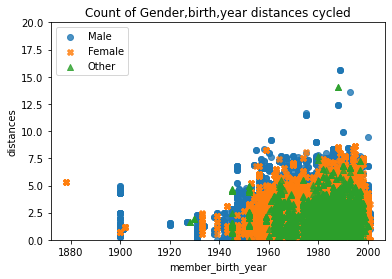

In [1347]:
xbin = np.arange(df['member_birth_year'].min(), df['member_birth_year'].max()+5, 5)
ybin = np.arange(0, (2133+ 1.5*1247)+500, 500)

cat_markers = [['Male', 'o'],
               ['Female', 'X'],
               ['Other','^']]

for cat, marker in cat_markers:
    df_temp = df.sample(300000, random_state=42, replace=True)
    plot_dat = df_temp[df_temp['member_gender'] == cat]
    sns.regplot(data = plot_dat, x = 'member_birth_year', y = 'distances', marker = marker,fit_reg=False);
plt.legend(['Male','Female','Other'])
plt.title("Count of Gender,birth,year distances cycled");
plt.ylim((0,20));

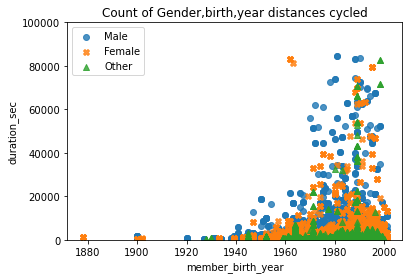

In [1359]:
xbin = np.arange(df['member_birth_year'].min(), df['member_birth_year'].max()+5, 5)
ybin = np.arange(0, (2133+ 1.5*1247)+500, 500)

cat_markers = [['Male', 'o'],
               ['Female', 'X'],
               ['Other','^']]

for cat, marker in cat_markers:
    df_temp = df.sample(300000, random_state=42, replace=True)
    plot_dat = df_temp[df_temp['member_gender'] == cat]
    sns.regplot(data = plot_dat, x = 'member_birth_year', y = 'duration_sec', marker = marker,fit_reg=False);
plt.legend(['Male','Female','Other'])
plt.title("Count of Gender,birth,year distances cycled");
plt.ylim((0,100000));

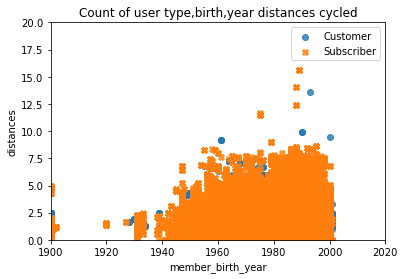

In [1350]:
xbin = np.arange(df['member_birth_year'].min(), df['member_birth_year'].max()+5, 5)
ybin = np.arange(0, (2133+ 1.5*1247)+500, 500)

cat_markers = [['Customer', 'o'],
               ['Subscriber', 'X'],]

for cat, marker in cat_markers:
    df_temp = df.sample(300000, random_state=42, replace=True)
    plot_dat = df_temp[df_temp['user_type'] == cat]
    sns.regplot(data = plot_dat, x = 'member_birth_year', y = 'distances', marker = marker,fit_reg=False);
plt.legend(['Customer','Subscriber'])
plt.title("Count of user type,birth,year distances cycled");
plt.ylim((0,20));
plt.xlim(1900,2020);

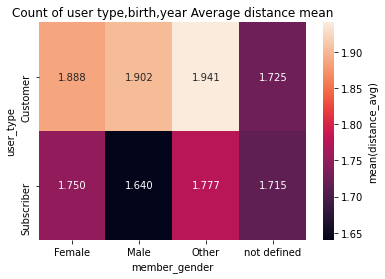

In [1348]:
cat_means = df.groupby(['member_gender', 'user_type']).mean()['distances']
cat_means = cat_means.reset_index(name = 'distance_avg')
cat_means = cat_means.pivot(index = 'user_type', columns = 'member_gender',
                            values = 'distance_avg')
sns.heatmap(cat_means, annot = True, fmt = '.3f',
           cbar_kws = {'label' : 'mean(distance_avg)'});
plt.title("Count of user type,birth year Average distance mean");

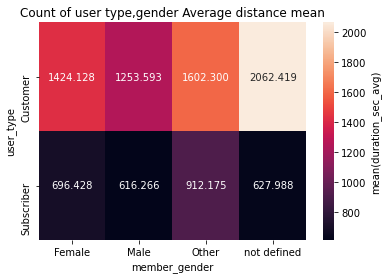

In [1349]:
cat_means = df.groupby(['member_gender', 'user_type']).mean()['duration_sec']
cat_means = cat_means.reset_index(name = 'duration_sec_avg')
cat_means = cat_means.pivot(index = 'user_type', columns = 'member_gender',
                            values = 'duration_sec_avg')
plt.title("Count of user type,gender Average distance mean");
sns.heatmap(cat_means, annot = True, fmt = '.3f',
           cbar_kws = {'label' : 'mean(duration_sec_avg)'});

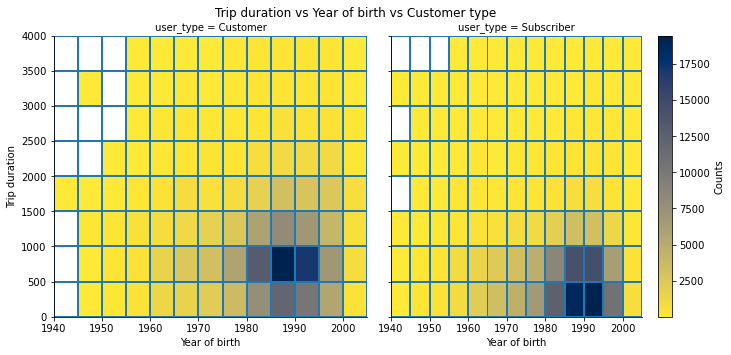

In [1383]:
xbin = np.arange(1940, df['member_birth_year'].max()+5, 5)
ybin = np.arange(0, 4500, 500)

grid = sns.FacetGrid(data = df, col = 'user_type',height=5)
grid.map(plt.hist2d, 'member_birth_year','duration_sec',cmin=0.5,cmap = 'cividis_r',bins=[xbin, ybin]);
plt.colorbar().set_label('Counts');

plt.subplots_adjust(top=0.9)
grid.fig.suptitle("Trip duration vs Year of birth vs Customer type");

grid.set_ylabels("Trip duration");
grid.set_xlabels("Year of birth");

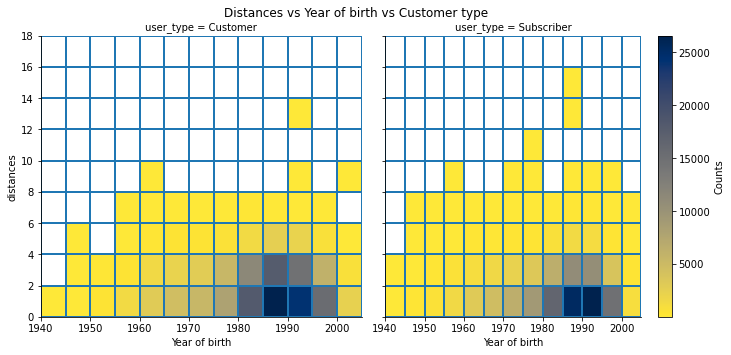

In [1382]:
xbin = np.arange(1940, df['member_birth_year'].max()+5, 5)
ybin = np.arange(0, 20, 2)

grid = sns.FacetGrid(data = df, col = 'user_type',height=5)
grid.map(plt.hist2d, 'member_birth_year','distances',cmin=0.5,cmap = 'cividis_r',bins=[xbin, ybin]);
plt.colorbar().set_label('Counts');

plt.subplots_adjust(top=0.9)
grid.fig.suptitle("Distances vs Year of birth vs Customer type");

grid.set_ylabels("distances");
grid.set_xlabels("Year of birth");

In [1381]:
df['distances'].describe

<bound method NDFrame.describe of 0         0.54
1         1.74
2         2.70
3         0.26
4         2.41
          ... 
183407    1.46
183408    1.40
183409    0.38
183410    0.75
183411    0.71
Name: distances, Length: 183215, dtype: float64>

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

* Customers cycled over double the average duration than subscribers. The not defined gender cycled for the longest durations, which means either, male or female didn't specify their gender or there were outliers in the data.

* The average distances didn't vary greatly between customers and subscribers, which means there could have been long periods of time where people weren't cycling, because greater cycling durations should equal greater distances cycled.

* distances greater than 12km cycled were only by users born between 1990 and 2000, but these could be outliers.
* Any distance recorded over 10km was by a male user.
* it can be seen that users males cycled the farthest distances, followed by females, then other.


### Were there any interesting or surprising interactions between features?

* 

In [1360]:
df.to_csv("master_data_frame.csv", sep=',', encoding='utf-8')

## Conclusions
- This data covers three areas: San Francisco, East Bay and San José
- There are alot more male users than other users, for all areas there are always over 64% male
- There are a lot more subscribers than customer using this service
- The average user over all data is most likely between 24 and 35 years old
- People use the bikes more/in higher counts during the week than during the weekend
- The majority of trips are less than 2km long.
- There is an increasing trend of usage
- People start their trips most frequently at 8 and 17 'o clock

During this project I had to clean the data and used folium to plot the Lat Long start and finish locations to visualise the journeys.
I analysed the data by plotting exploratory graphs, then used Univariate, Bivariate and Multivariate graphs to further explore the relationships and trends od duration and distances cycled by age, gender and user type.
I felt ther was no major surprises from the findings, other than males were the majority of users.


References

* https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
* https://www.datasciencemadesimple.com/pie-chart-in-python-with-legends/
* https://data.sfgov.org/Housing-and-Buildings/Land-Use/us3s-fp9q
* https://colab.research.google.com/drive/1MQQ3wUkMFQHLSJ9L4zjkueqet_PyJuyS#scrollTo=iOvl-TgaBm-G
* https://datascientyst.com/get-most-frequent-values-pandas-dataframe/
* https://colab.research.google.com/drive/1MQQ3wUkMFQHLSJ9L4zjkueqet_PyJuyS#scrollTo=hzbPtRDhfSrq
* https://www.findlatitudeandlongitude.com/
* https://datascientyst.com/plot-latitude-longitude-pandas-dataframe-python/
* https://towardsdatascience.com/calculating-distance-between-two-geolocations-in-python-26ad3afe287b
* https://www.w3resource.com/python-exercises/math/python-math-exercise-27.php
    
    